In [1]:
import warnings
warnings.filterwarnings('ignore')
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

1.15.0
/device:GPU:0


## **Drive Mount**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Imports**

In [3]:
import os
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Activation, CuDNNLSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


## **Project Level Contants**

In [0]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

PROJECT_DIR = '/content/gdrive/My Drive/MS_Project'
OUTPUT_DIR = '/content/gdrive/My Drive/MS_Project/Char_Level'

if not os.path.exists(PROJECT_DIR):
    os.path.mkdir(PROJECT_DIR)

if not os.path.exists(OUTPUT_DIR):
    os.path.mkdir(OUTPUT_DIR)

INPUT_FILE = 'django.txt'

In [5]:
HIDDEN_UNITS = 512
HIDDEN_LAYERS = 3

LOAD_PRETRAINED_MODEL = True

WEIGHTS_FILE = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L'
WEIGHTS_FILE += '_checkpoint.h5'
print(WEIGHTS_FILE)

django_512U_3L_checkpoint.h5


## **Preprocessing**

In [6]:
input_file_path = os.path.join(PROJECT_DIR, INPUT_FILE)

with open(input_file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

import string
raw_text = ''.join(filter(lambda x: x in string.printable, raw_text))

# import re
# re.sub(r'[^\x00-\x7f]',r'', raw_text)

print(raw_text[:100])


unique_chars = sorted(list(set(raw_text)))
n_features = n_uniq_chars = len(unique_chars)
print(n_uniq_chars, unique_chars)



char_index = {}
index_char = {}
for idx, char in enumerate(unique_chars):
    char_index[char] = idx
    index_char[idx] = char


/Users/Shubham/Downloads/django/setup.py
import os
import sys
from distutils.sysconfig import get_py
96 ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


In [7]:
max_len_seq = 60
n_datapoints = len(raw_text)//max_len_seq

data = np.zeros((n_datapoints, max_len_seq, n_uniq_chars))
labels = np.zeros((n_datapoints, max_len_seq, n_uniq_chars))

for i in range(n_datapoints):
    input_sentence = raw_text[i*max_len_seq: (i+1)*max_len_seq]
    input_seq = [char_index[char] for char in input_sentence]
    one_hot_input = np.zeros((max_len_seq, n_uniq_chars))
    for j in range(len(input_seq)):
        one_hot_input[j][input_seq[j]] = 1
    
    data[i] = one_hot_input

    target_sentence = raw_text[i*max_len_seq + 1: (i+1)*max_len_seq + 1]
    target_seq = [char_index[char] for char in target_sentence]
    one_hot_target = np.zeros((max_len_seq, n_uniq_chars))

    for j in range(len(target_seq)):
        one_hot_target[j][target_seq[j]] = 1
    
    labels[i] = one_hot_target


print(data.shape, data[:1])
print(labels.shape, labels[:1])

train_data = data
train_labels = labels


(108725, 60, 96) [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(108725, 60, 96) [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


## **Train and Test Split**

In [0]:
from sklearn.model_selection import train_test_split


# create train and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

print('Train shape:', train_data.shape, 'Val shape:', test_data.shape)
print('Train Labels shape:', train_labels.shape, 'Val Labels shape:', test_labels.shape)

## **Load Pretrained Model**

In [8]:
if LOAD_PRETRAINED_MODEL:
  weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)
  if os.path.exists(weight_file_path):
    model = load_model(weight_file_path)
    print('Model Loaded')
  else:
    print('Model Does not exist')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model Loaded


## **Model**

#### Perplexity

In [0]:
import keras.backend as K
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

In [11]:
if not LOAD_PRETRAINED_MODEL:
  model = Sequential()
  model.add(CuDNNLSTM(HIDDEN_UNITS, input_shape=(None, n_uniq_chars), return_sequences=True))

  for _ in range(HIDDEN_LAYERS - 1):
      model.add(CuDNNLSTM(HIDDEN_UNITS, return_sequences=True))
      model.add(Dropout(0.5))

  model.add(TimeDistributed(Dense(n_uniq_chars)))
  model.add(Activation('softmax'))
  print(model.summary())

  optimizer = Adam()
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[perplexity, 'acc'])
else:
  print('Model already loaded')
  print(model.summary())

Model already loaded
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 512)         1247232   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 96)          49248     
_________________________________________________________________
activation_1 (Activation)    (Non

## **Training**

#### Sampling based on temperature

In [0]:
# Snippet taken from : https://keras.io/examples/lstm_text_generation/
def sample(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### ***Do Not Run If Loading Saved Model***


In [18]:
def generate_text_callback(model, length=100, seed_text=''):
    temps = [0.5, 0.8]
    output = {}
    X = np.zeros((1, length, n_uniq_chars))
    init_char_idx = np.random.randint(0, n_uniq_chars-1)

    start_len = 0
    if seed_text:
        for i in range(len(seed_text)-1):
            X[0, i, char_index[seed_text[i]]] = 1
        start_len = len(seed_text)
        init_char_idx = char_index[seed_text[-1]]

    for temp in temps:
        idx = init_char_idx
        output[temp] = [index_char[idx]]
        print(f'*** For temperature: {temp}***')
        if seed_text:
            print(seed_text[:-1], end='')

        print(index_char[idx], end='')

        for i in range(start_len, length):
            X[0, i] = np.zeros(n_uniq_chars)
            X[0, i, idx] = 1
            preds = model.predict(X[:, :i+1, :], )[0][-1]
            idx = sample(preds, temp)
            print(index_char[idx], end='')

            output[temp].append(index_char[idx])

        print('\n\n')

    # for temp in output:
    #     output[temp] = ('').join(output[temp])

    return output


class GenerateText(Callback):
    def on_epoch_end(self, batch, logs={}):
        generate_text_callback(self.model, 100)
        # for temp in output:
        #     print(f'For temperature: {temp}')
        #     print(output[temp])


weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)

model_checkpoint_cb = ModelCheckpoint(weight_file_path, monitor='loss', verbose=1, 
                                save_best_only=True, mode='min')

early_stopping_cb = EarlyStopping(monitor='loss', patience=5)
generate_text_cb = GenerateText()

history = model.fit(data, labels, batch_size=128, epochs=100, verbose=1, validation_split=0.2,
          callbacks=[early_stopping_cb, generate_text_cb, model_checkpoint_cb])

Train on 60166 samples, validate on 15042 samples
Epoch 1/100
60166/60166 [==============================] - 120s 2ms/step - loss: 2.3876 - perplexity: 13.5888 - acc: 0.3917 - val_loss: 1.5644 - val_perplexity: 10.7970 - val_acc: 0.5771
*** For temperature: 0.5***
Tes.
                    if not self.defiul_contime_check = self.get_detare field = self._return_cons


*** For temperature: 0.8***
Taln Loeed in has conderuted.
                        self.ger_field.inder_name(self.re_dematied_nequ



Epoch 00001: loss improved from inf to 2.38763, saving model to /content/gdrive/My Drive/MS_Project/Char_Level/django_testless_512U_3L_checkpoint.h5
Epoch 2/100
60166/60166 [==============================] - 116s 2ms/step - loss: 1.4819 - perplexity: 9.8829 - acc: 0.6024 - val_loss: 1.2015 - val_perplexity: 8.8164 - val_acc: 0.6688
*** For temperature: 0.5***
> (has_params):
                    self.fields = self.template_names = self.get_connection(self.cont


*** For temperature: 0.8***
> re

## **Testing the Model**

In [0]:
model.evaluate(test_data, test_labels, batch_size=64, verbose=1)

## **Load Saved Model**

In [8]:
weight_file_path = os.path.join(OUTPUT_DIR, WEIGHTS_FILE)

if os.path.exists(weight_file_path):
    saved_model = load_model(weight_file_path)
    print('Saved Model Loaded')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Saved Model Loaded


## **Generating and Saving Texts**

In [0]:
# np.random.seed(0)

def generate_text(model, length=100, seed_text=''):
    
    
    temps = [0.5, 0.8]
    output = {}

    X = np.zeros((1, length, n_uniq_chars))
    init_char_idx = np.random.randint(0, n_uniq_chars-1)

    start_len = 0

    if seed_text:
        for i in range(len(seed_text)-1):
            X[0, i, char_index[seed_text[i]]] = 1
        start_len = len(seed_text)

        init_char_idx = char_index[seed_text[-1]]


    for temp in temps:

        idx = init_char_idx

        output[temp] = [index_char[idx]]
        print(f'*** For temperature: {temp}***')
        if seed_text:
            print(seed_text[:-1], end='')

        print(index_char[idx], end='')

        for i in range(start_len, length):
            X[0, i] = np.zeros(n_uniq_chars)
            X[0, i, idx] = 1
            # print(preds)
            preds = model.predict(X[:, :i+1, :], )[0][-1]

            idx = sample(preds, temp)
            print(index_char[idx], end='')

            output[temp].append(index_char[idx])

        print('\n\n')
    for temp in output:
        output[temp] = ('').join(output[temp])

    return output


output = generate_text(model, 2000, seed_text='c')


OUTPUT_FILE = INPUT_FILE.split('.')[0] + '_' + str(HIDDEN_UNITS) + 'U_' + str(HIDDEN_LAYERS) + 'L'

with open(os.path.join(OUTPUT_DIR , OUTPUT_FILE+'.py'), 'a+') as f:
    f.write('#*********New Text********\n')    
    f.write('\n\n')

    for temp in output:
        f.write(f'#*** For temperature: {temp} ***\n')
        f.write(output[temp])
        f.write('\n\n')

    f.write('\n\n\n\n\n')


## Plot

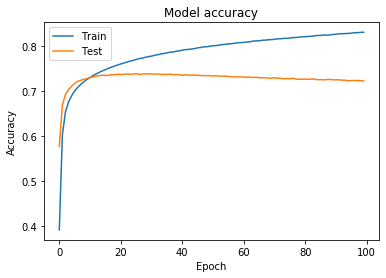

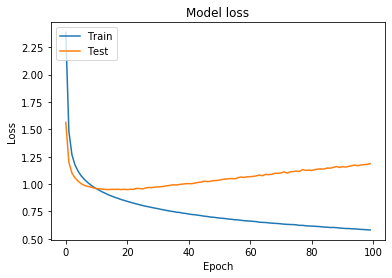

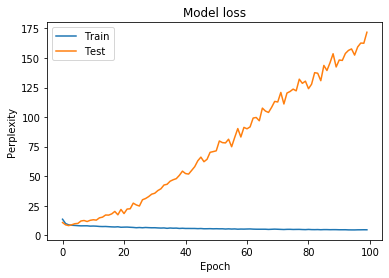

In [23]:
# snippet taken from https://keras.io/visualization/
import json
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])
plt.title('Model loss')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()